# Телеком

## <b>Техническое задание </b>

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Задача — обучить на этих данных модель для прогноза оттока клиентов.
<br><b>Описание услуг</b>
<br>Оператор предоставляет два основных типа услуг:
<br>Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
<br>Интернет. Подключение бывает двух типов: через телефонную линию DSL (англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (англ. fiber optic).
<br><b>Также абонентам доступен ряд услуг:</b>
<br>Интернет-безопасность: антивирус (Device Protection) и блокировка опасных сайтов (Online Security);
<br>Выделенная линия технической поддержки (Tech Support);
<br>Облачное хранилище файлов для резервного копирования данных (Online Backup);
<br>Стриминговое телевидение (Streaming TV) и каталог фильмов (Streaming Movies).
<br>За услуги клиенты могут платить ежемесячно или раз в 1–2 года. Доступны различные способы расчёта и возможность получить электронный чек.

## <b>Описание данных</b>

<b>contract</b>
<br>customerID — ID абонента;
<br>BeginDate — дата начала действия договора;
<br>EndDate — дата окончания действия договора;
<br>Type — тип оплаты: раз в год-два или ежемесячно;
<br>PaperlessBilling — электронный расчётный лист;
<br>PaymentMethod — тип платежа;
<br>MonthlyCharges — расходы за месяц;
<br>TotalCharges — общие расходы абонента.
<br><b>personal</b>
<br>customerID — ID пользователя;
<br>gender — пол;
<br>SeniorCitizen — является ли абонент пенсионером;
<br>Partner — есть ли у абонента супруг или супруга;
<br>Dependents — есть ли у абонента дети.
<br><b>internet</b>
<br>customerID — ID пользователя;
<br>InternetService — тип подключения;
<br>OnlineSecurity — блокировка опасных сайтов;
<br>OnlineBackup — облачное хранилище файлов для резервного копирования данных;
<br>DeviceProtection — антивирус;
<br>TechSupport — выделенная линия технической поддержки;
<br>StreamingTV — стриминговое телевидение;
<br>StreamingMovies — каталог фильмов.
<br><b>phone</b>
<br>customerID — ID пользователя;
<br>MultipleLines — подключение телефона к нескольким линиям одновременно.

## <b>Импорт библиотек и функций</b>

In [1]:
import os
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

import seaborn as sns, numpy as np
import matplotlib.pyplot as mp
from matplotlib import pyplot as plt

from datetime import datetime

from phik.report import plot_correlation_matrix

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
RANDOM_STATE = 300625 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold

from sklearn.feature_selection import SelectKBest, mutual_info_classif 
from sklearn.metrics import confusion_matrix


import warnings
warnings.filterwarnings('ignore')

In [2]:
line = '-'*132

def percentage_passes (dataset):
    print(dataset.info())
    print(line)
    print('Количество пропущенных значений таблицы:')
    for col in dataset.columns:
        datcol = np.sum(dataset[col].isnull())
        print(col, datcol)  
        
    print(line)
    print('Количество дубликатов -', dataset.duplicated().sum())

def data_analysis_0(variable, column):
    means = variable[column].mean()
    medians = variable[column].median()
    
    
    sns.set()
    f, axes = plt.subplots(1, 2, figsize=(16, 4))
    axes[0].hist(variable[column], bins=20, alpha=0.5)  
    axes[0].axvline(x=means, color='green')
    axes[0].axvline(x=medians, color='red')
    axes[0].legend(['Среднее значение - {:.2f}'.format(means),
                    'Медианное значение - {:.2f}'.format(medians)])
    axes[0].set_title(f'Гистограмма для - {column}', fontsize=15)
    axes[0].set_ylabel('Количество', fontsize=10)

def data_analysis (variable, column):
    means = variable[column].mean()
    medians = variable[column].median()
    sns.set()
    f, axes = plt.subplots(1, 2, figsize=(16, 4))
    axes[0].axvline(x=means, color='green')
    axes[0].axvline(x=medians, color='red')
    axes[0].legend(['Среднее значение - {:.2f}'.format(means),
                    'Медианное значение - {:.2f}'.format(medians)])
    axes[0].set_title(f'Гистограмма для - {column}', fontsize=15)
    axes[0].set_ylabel('Количество', fontsize=10)
    
    sns.histplot(variable, bins=20, kde=True, ax=axes[0], x=column)
    axes[1].set_title(f'График ящик с усами для - {column}', fontsize=15)
    sns.boxplot(data=variable, ax=axes[1], y=column)
    axes[1].set_ylabel(column, fontsize=10)
    plt.show()
    
def direct_diagram(variable, column):
    display(variable[column].unique())
    plt.figure(figsize=(8,6))
    plot = sns.countplot(y=column, data=variable)
    plot.set_title(f'Рапределение по - {column}', fontsize=15)
    plot.set_xlabel('Количество', fontsize=10)
    plt.show()
    
def radial_diagram (variable, column):
    sns.set()
    variable[column].value_counts().head(10).plot(y='subscription_type', kind='pie',figsize=(6,6), autopct='%1.1f%%')
    mp.title(f'Диаграмма для - {column}')
    mp.ylabel("")
    mp.show()

## <b>Загрузка и изучение данных</b>

 Подключение к БД.

In [3]:
path_to_db = 'ds-plus-final.db'
engine = create_engine(f'sqlite:///{path_to_db}', echo=False)

### contract

In [4]:
query = '''
SELECT *
FROM contract
'''
contract = pd.read_sql_query(query, con = engine) 

percentage_passes (contract)
contract.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   BeginDate         7043 non-null   object
 2   EndDate           7043 non-null   object
 3   Type              7043 non-null   object
 4   PaperlessBilling  7043 non-null   object
 5   PaymentMethod     7043 non-null   object
 6   MonthlyCharges    7043 non-null   object
 7   TotalCharges      7043 non-null   object
dtypes: object(8)
memory usage: 440.3+ KB
None
------------------------------------------------------------------------------------------------------------------------------------
Количество пропущенных значений таблицы:
customerID 0
BeginDate 0
EndDate 0
Type 0
PaperlessBilling 0
PaymentMethod 0
MonthlyCharges 0
TotalCharges 0
--------------------------------------------------------------------------------------------------------

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.3,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.7,353.5


Приведу столбцы к верному типу данных. 

В процессе обработки выяснилось, что строка 488 имеет пропуск в виде пробела. Заменю пробел на медианное значение, так как оно не зависит от выбросов. Т.е. оно показывает более правдивое среднее число которое не критично меняется от одного большого числа. 

In [5]:
contract.iloc[488]

customerID                         4472-LVYGI
BeginDate                          2020-02-01
EndDate                                    No
Type                                 Two year
PaperlessBilling                          Yes
PaymentMethod       Bank transfer (automatic)
MonthlyCharges                          52.55
TotalCharges                                 
Name: 488, dtype: object

In [6]:
contract.TotalCharges = contract.TotalCharges.str.replace(" ", '1349.71')

In [7]:
contract.MonthlyCharges = contract.MonthlyCharges.astype(float)

contract.TotalCharges = contract.TotalCharges.astype(float)

In [8]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])

In [9]:
print('Количество уникальных значений столбца - customerID:', contract.customerID.nunique())
print(line)
print('Уникальные значения столбца - EndDate:', contract.EndDate.unique())
print(line)
print('Уникальные значения столбца - Type:', contract.Type.unique())
print(line)
print('Уникальные значения столбца - PaymentMethod:', contract.PaymentMethod.unique())

Количество уникальных значений столбца - customerID: 7043
------------------------------------------------------------------------------------------------------------------------------------
Уникальные значения столбца - EndDate: ['No' '2017-05-01' '2016-03-01' '2018-09-01' '2018-11-01' '2018-12-01'
 '2019-08-01' '2018-07-01' '2017-09-01' '2015-09-01' '2016-07-01'
 '2016-06-01' '2018-03-01' '2019-02-01' '2018-06-01' '2019-06-01'
 '2020-01-01' '2019-11-01' '2016-09-01' '2015-06-01' '2016-12-01'
 '2019-05-01' '2019-04-01' '2017-06-01' '2017-08-01' '2018-04-01'
 '2018-08-01' '2018-02-01' '2019-07-01' '2015-12-01' '2014-06-01'
 '2018-10-01' '2019-01-01' '2017-07-01' '2017-12-01' '2018-05-01'
 '2015-11-01' '2019-10-01' '2019-03-01' '2016-02-01' '2016-10-01'
 '2018-01-01' '2017-11-01' '2015-10-01' '2019-12-01' '2015-07-01'
 '2017-04-01' '2015-02-01' '2017-03-01' '2016-05-01' '2016-11-01'
 '2015-08-01' '2019-09-01' '2017-10-01' '2017-02-01' '2016-08-01'
 '2016-04-01' '2015-05-01' '2014-09-01'

In [10]:
contract.PaymentMethod = contract.PaymentMethod.replace("Bank transfer (automatic)", "Bank transfer automatic")
contract.PaymentMethod = contract.PaymentMethod.replace("Credit card (automatic)", "Credit card automatic")

In [11]:
contract = contract.applymap(lambda x: x.lower() if type(x) == str else x)  

contract.columns = map(str.lower, contract.columns)

Таблица contract имеет 7043 строки и 8 столбцов. Данные не содержат пропусков, а также дубликатов/неявных дубликатов. Текст приведен к нижнему регистру. Пользователи не повторяются.

### personal

In [12]:
query = '''
SELECT *
FROM personal
'''
personal = pd.read_sql_query(query, con = engine) 

percentage_passes (personal)
personal.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   object
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB
None
------------------------------------------------------------------------------------------------------------------------------------
Количество пропущенных значений таблицы:
customerID 0
gender 0
SeniorCitizen 0
Partner 0
Dependents 0
------------------------------------------------------------------------------------------------------------------------------------
Количество дубликатов - 0


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [13]:
print('Количество уникальных значений столбца - customerID:', personal.customerID.nunique())
print(line)
print('Уникальные значения столбца - gender:', personal.gender.unique())
print(line)
print('Уникальные значения столбца - SeniorCitizen:', personal.SeniorCitizen.unique())
print(line)
print('Уникальные значения столбца - Partner:', personal.Partner.unique())
print(line)
print('Уникальные значения столбца - Partner:', personal.Dependents.unique())

Количество уникальных значений столбца - customerID: 7043
------------------------------------------------------------------------------------------------------------------------------------
Уникальные значения столбца - gender: ['Female' 'Male']
------------------------------------------------------------------------------------------------------------------------------------
Уникальные значения столбца - SeniorCitizen: ['0' '1']
------------------------------------------------------------------------------------------------------------------------------------
Уникальные значения столбца - Partner: ['Yes' 'No']
------------------------------------------------------------------------------------------------------------------------------------
Уникальные значения столбца - Partner: ['No' 'Yes']


In [14]:
personal = personal.applymap(lambda x: x.lower() if type(x) == str else x)  

personal.columns = map(str.lower, personal.columns)

Таблица personal имеет 7043 строки и 5 столбцов. Данные не содержат пропусков, а также дубликатов/неявных дубликатов. Текст приведен к нижнему регистру. Пользователи не повторяются.

### internet

In [15]:
query = '''
SELECT *
FROM internet
'''
internet = pd.read_sql_query(query, con = engine) 

percentage_passes (internet)
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None
------------------------------------------------------------------------------------------------------------------------------------
Количество пропущенных значений таблицы:
customerID 0
InternetService 0
OnlineSecurity 0
OnlineBackup 0
DeviceProtection 0
TechSupport 0
StreamingTV 0
StreamingMovies 0
-------------------------------------------------------------------------------------

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [16]:
print('Количество уникальных значений столбца - customerID:', internet.customerID.nunique())
print(line)
print('Уникальные значения столбца - InternetService:', internet.InternetService.unique())
print(line)
print('Уникальные значения столбца - OnlineSecurity:', internet.OnlineSecurity.unique())
print(line)
print('Уникальные значения столбца - OnlineBackup:', internet.OnlineBackup.unique())
print(line)
print('Уникальные значения столбца - DeviceProtection:', internet.DeviceProtection.unique())
print(line)
print('Уникальные значения столбца - TechSupport:', internet.TechSupport.unique())
print(line)
print('Уникальные значения столбца - StreamingTV:', internet.StreamingTV.unique())
print(line)
print('Уникальные значения столбца - StreamingMovies:', internet.StreamingMovies.unique())

Количество уникальных значений столбца - customerID: 5517
------------------------------------------------------------------------------------------------------------------------------------
Уникальные значения столбца - InternetService: ['DSL' 'Fiber optic']
------------------------------------------------------------------------------------------------------------------------------------
Уникальные значения столбца - OnlineSecurity: ['No' 'Yes']
------------------------------------------------------------------------------------------------------------------------------------
Уникальные значения столбца - OnlineBackup: ['Yes' 'No']
------------------------------------------------------------------------------------------------------------------------------------
Уникальные значения столбца - DeviceProtection: ['No' 'Yes']
------------------------------------------------------------------------------------------------------------------------------------
Уникальные значения столбца - T

In [17]:
internet = internet.applymap(lambda x: x.lower() if type(x) == str else x)  

internet.columns = map(str.lower, internet.columns)

Таблица internet имеет 5517 строк (меньше, чем в двух предыдущих датафреймах) и 8 столбцов. Данные не содержат пропусков, а также дубликатов/неявных дубликатов. Текст приведен к нижнему регистру. Пользователи не повторяются. 

### phone

In [18]:
query = '''
SELECT *
FROM phone
'''
phone = pd.read_sql_query(query, con = engine) 

percentage_passes (phone)
phone.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerId     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None
------------------------------------------------------------------------------------------------------------------------------------
Количество пропущенных значений таблицы:
CustomerId 0
MultipleLines 0
------------------------------------------------------------------------------------------------------------------------------------
Количество дубликатов - 0


,CustomerId,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [19]:
print('Количество уникальных значений столбца - customerID:', phone.CustomerId.nunique())
print(line)
print('Уникальные значения столбца - phone:', phone.MultipleLines.unique())

Количество уникальных значений столбца - customerID: 6361
------------------------------------------------------------------------------------------------------------------------------------
Уникальные значения столбца - phone: ['No' 'Yes']


In [20]:
phone = phone.applymap(lambda x: x.lower() if type(x) == str else x)  

phone.columns = map(str.lower, phone.columns)

Таблица phone имеет 6361 строк (меньше, чем в первых двух датафреймах, но больше, чем в предыдущем) и 2 столбца. Данные не содержат пропусков, а также дубликатов/неявных дубликатов. Текст приведен к нижнему регистру. Пользователи не повторяются.

Вывод
<br>---------------------------------------
<br>contract - 7043 строк. 
<br>personal - 7043 строк. 
<br>internet - 5517 строк. 
<br>phone - 6361 строк. 
<br>Во всех таблицах нет ни пропусков, ни дубликатов. Текст приведен в нижний регистр. 

## <b>Исследовательский анализ</b>

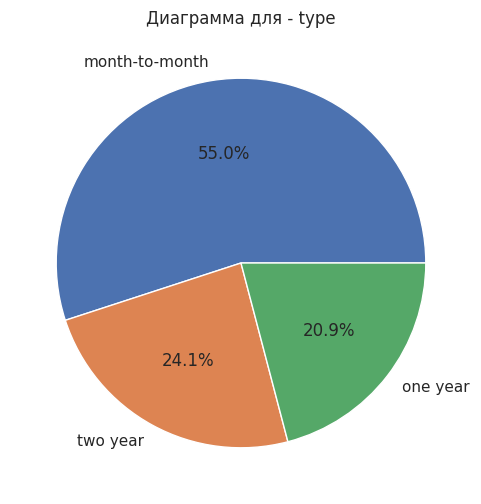

------------------------------------------------------------------------------------------------------------------------------------


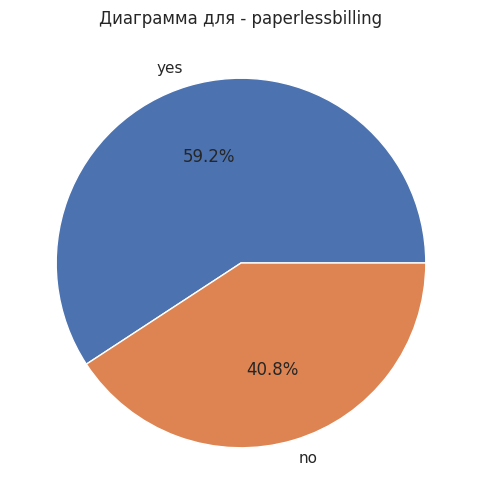

------------------------------------------------------------------------------------------------------------------------------------


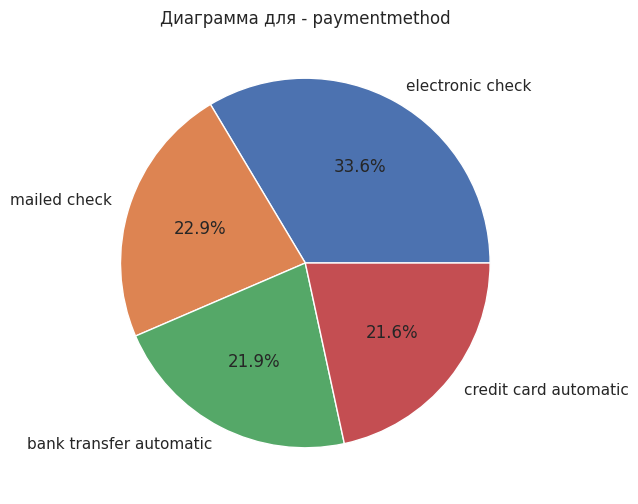

------------------------------------------------------------------------------------------------------------------------------------


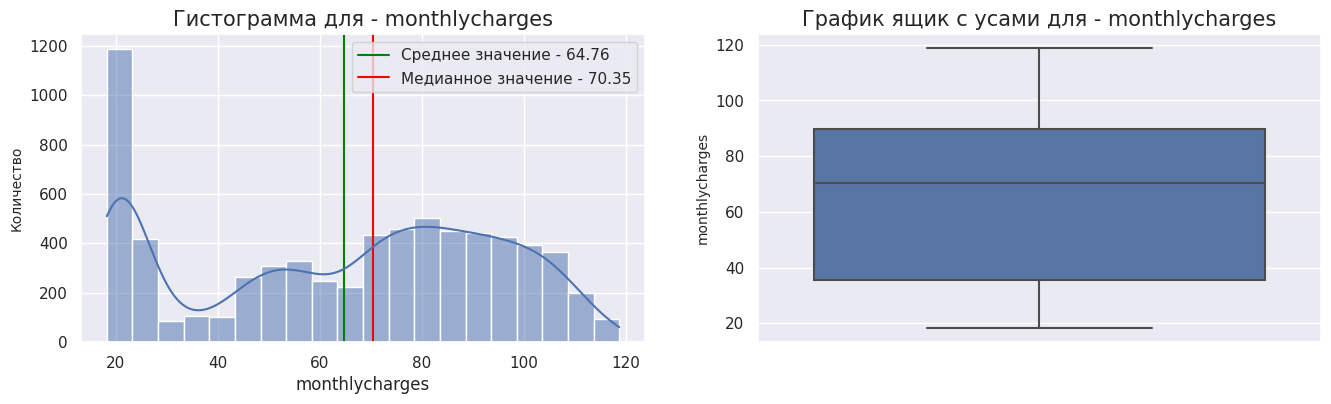

------------------------------------------------------------------------------------------------------------------------------------


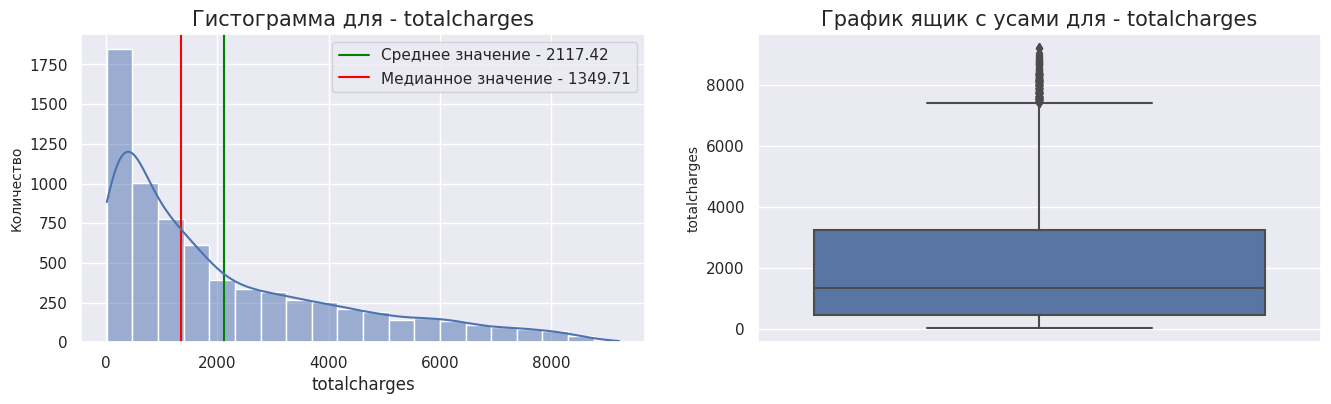

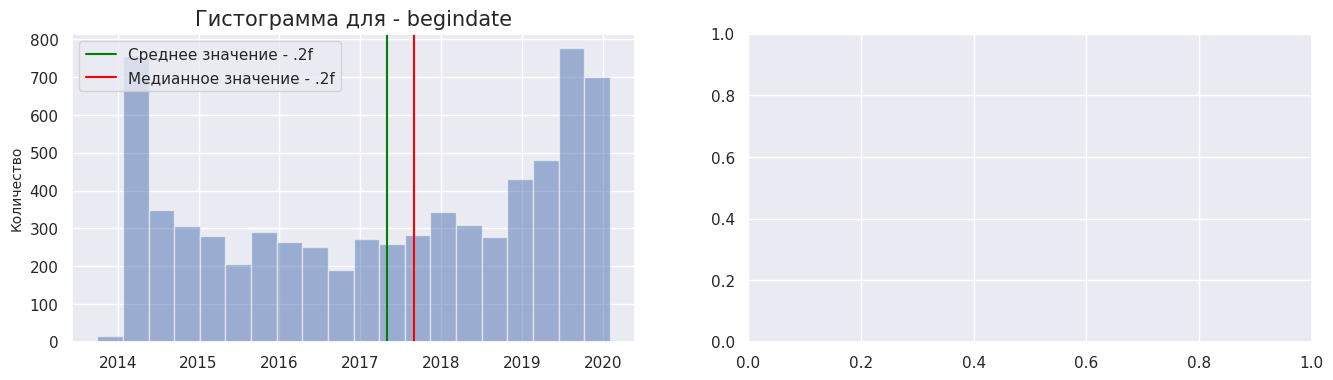

In [21]:
parameters =  list(contract.columns)
del parameters[0:3] 
del parameters[3:5] 

for param in parameters:
    radial_diagram(contract, param)
    print(line)

data_analysis(contract, 'monthlycharges')
print(line)
data_analysis(contract, 'totalcharges')

pd.set_option('display.max_rows', None)


data_analysis_0(contract, 'begindate')

Вывод по таблице contract. 
<br>Половина пользователей предпочитают оплачивать услуги ежемесячно. Остальная половина делит между собой оплату раз в год/два. Это может быть связано с тем, что оплата за весь год/два может быть более накладной в финансовом плане. 60% клиентов имеют электронный расчётный лист. По типу платежа можно выделить, что больше всего (33%) оплачивают электронно. Неизвестно, с чего складываются расходы, скорее всего, это разные недорогие доп. услуги. Большинство людей ими не пользуются, а если и подключают/покупают, то расходы на такие услуги не привышают и 120 р. В среднем абонент тратит на услуги 65 р. в месяц или 2000 р. в год. Большая часть клиентов из таблицы заключила договор в 2014 и 19-20 годах. 

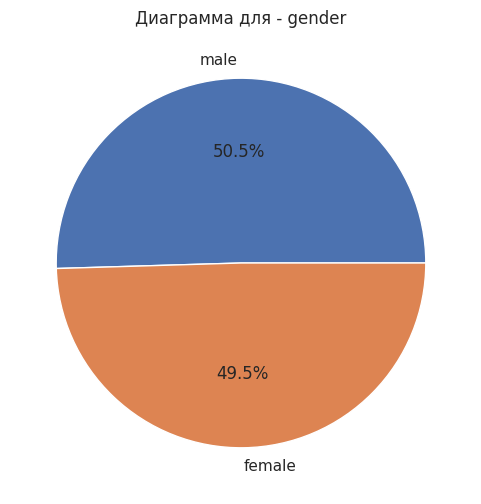

------------------------------------------------------------------------------------------------------------------------------------


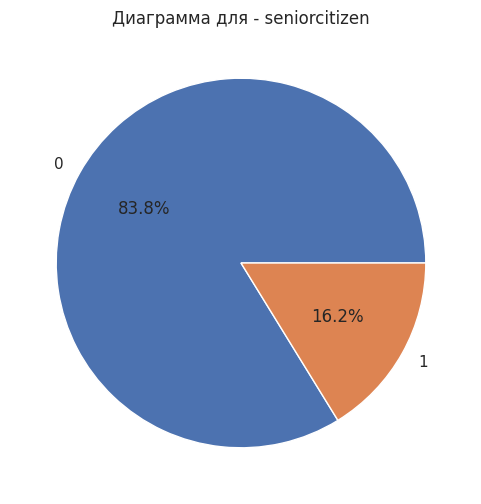

------------------------------------------------------------------------------------------------------------------------------------


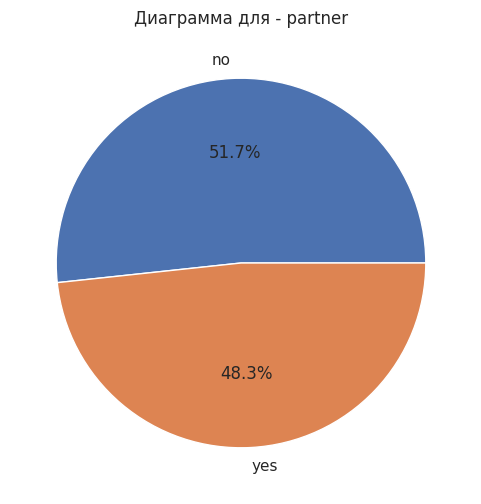

------------------------------------------------------------------------------------------------------------------------------------


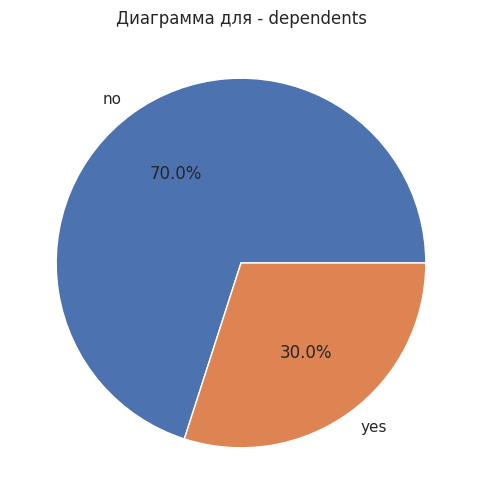

------------------------------------------------------------------------------------------------------------------------------------


In [22]:
parameters =  list(personal.columns)
del parameters[0]

for param in parameters:
    radial_diagram(personal, param)
    print(line)
    

Вывод по таблице personal. 
<br>Среднестатистического клиента можно описать так: это либо женщина, либо мужчина не пенсионного возраста, не замужем/женат, не имеет детей.

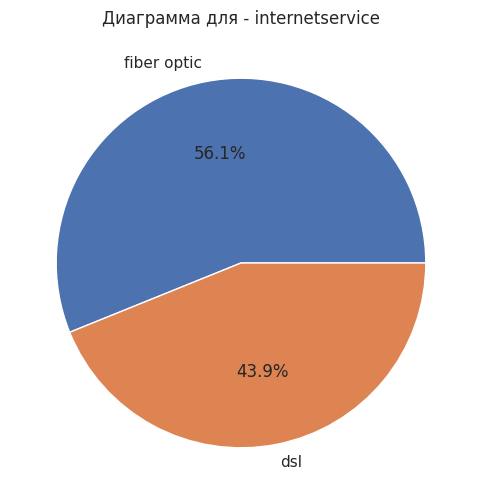

------------------------------------------------------------------------------------------------------------------------------------


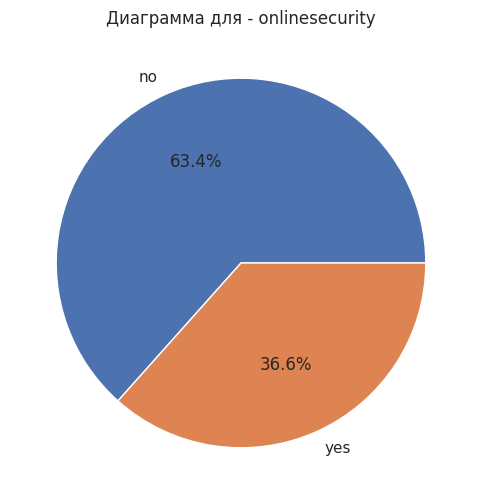

------------------------------------------------------------------------------------------------------------------------------------


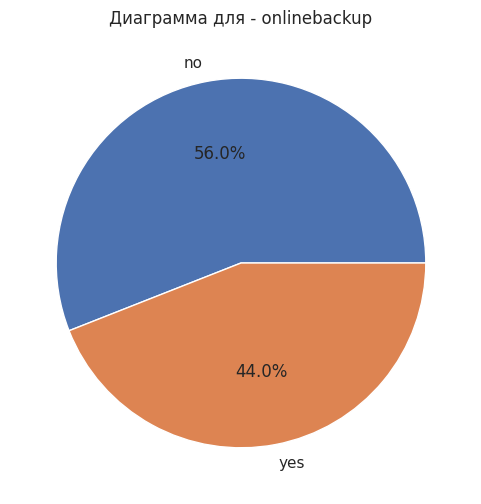

------------------------------------------------------------------------------------------------------------------------------------


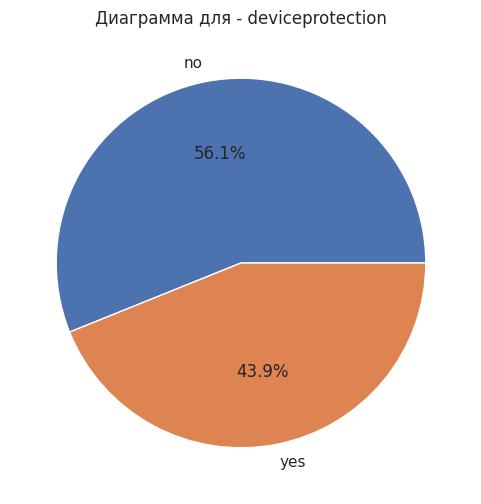

------------------------------------------------------------------------------------------------------------------------------------


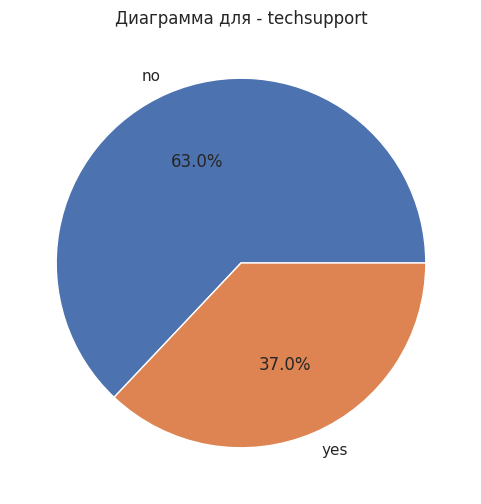

------------------------------------------------------------------------------------------------------------------------------------


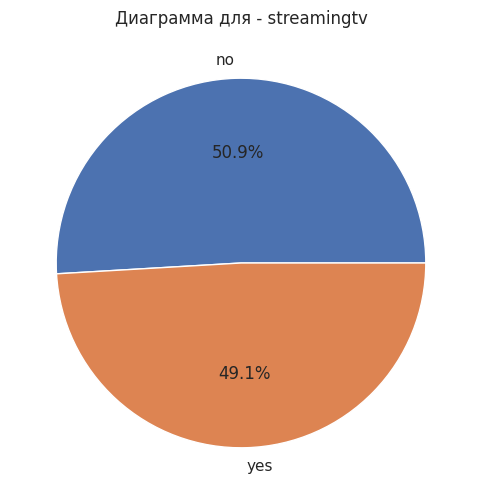

------------------------------------------------------------------------------------------------------------------------------------


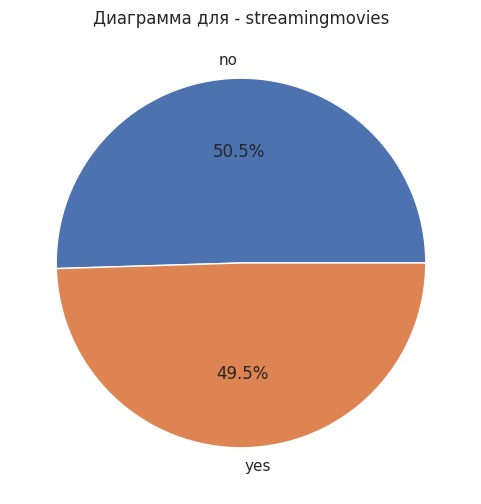

------------------------------------------------------------------------------------------------------------------------------------


In [23]:
parameters =  list(internet.columns)
del parameters[0]

for param in parameters:
    radial_diagram(internet, param)
    print(line)

Вывод по таблице internet. 
<br>Абоненты не так активно используют такие услуги, как блокировка опасных сайтов, облачное хранилище файлов для резервного копирования данных, антивирус, выделенная линия технической поддержки. Это сходится с таблицей contract, так как подобные услуги обычно продаются отдельно, а, судя по столбцам с тратами абонентов, которые составляют не очень много, такое распределение выглядит логичным. А вот что касается телевидения, то тут распределение уже 50:50.

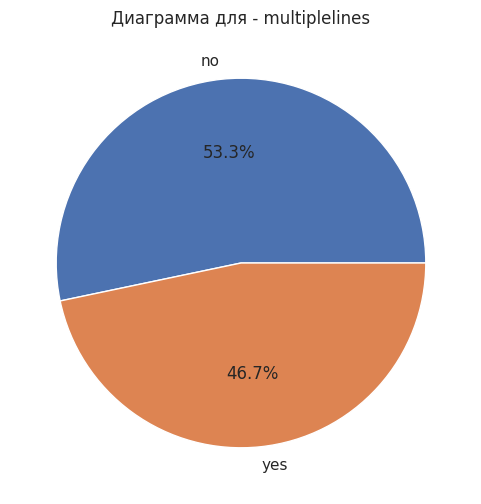

In [24]:
radial_diagram(phone, 'multiplelines')

Вывод по таблице phone. 
<br>Только половина людей подклила телефон к нескольким линиям.

### Объединение таблиц

In [25]:
data = contract.merge(personal, on ='customerid', how='left')

In [26]:
data = data.merge(internet, on ='customerid', how='left')

Заполню пропуски с соответствием названия таблицы. Так как мы не можем знать точно, что эти пользователи не подключали услуги, связанные с интернетом или телефоном, значит, пропуски заполню нейтральным значением, которое будет говорить, что пользователь не точно не использовал эту услугу.

In [27]:
data = data.fillna('no internet')

In [28]:
data = data.merge(phone, on ='customerid', how='left')

In [29]:
data = data.fillna('no phone')

In [30]:
percentage_passes(data)
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           7043 non-null   object        
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   seniorcitizen     7043 non-null   object        
 10  partner           7043 non-null   object        
 11  dependents        7043 non-null   object        
 12  internetservice   7043 non-null   object        
 13  onlinesecurity    7043 non-null   object        
 14  onlinebackup      7043 n

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
0,7590-vhveg,2020-01-01,no,month-to-month,yes,electronic check,29.85,31.04,female,0,yes,no,dsl,no,yes,no,no,no,no,no phone
1,5575-gnvde,2017-04-01,no,one year,no,mailed check,56.95,2071.84,male,0,no,no,dsl,yes,no,yes,no,no,no,no
2,3668-qpybk,2019-10-01,no,month-to-month,yes,mailed check,53.85,226.17,male,0,no,no,dsl,yes,yes,no,no,no,no,no
3,7795-cfocw,2016-05-01,no,one year,no,bank transfer automatic,42.30,1960.60,male,0,no,no,dsl,yes,no,yes,yes,no,no,no phone
4,9237-hqitu,2019-09-01,no,month-to-month,yes,electronic check,70.70,353.50,female,0,no,no,fiber optic,no,no,no,no,no,no,no


Пропуски в данных образовались из-за того, что таблицы internet и phone не содержат данных некоторых пользователей из страницы contract. Почему так — из-за того, что пользователи не пользовались услугами, описанными в этих таблицах. Но так-как это не 100% верно пропуски были заменены на нейтральное значение. 

Создам признак который будет содерждать в себе количество дней контракта клиента.

In [31]:
data['enddate'] = data['enddate'].replace('No', pd.NA)

data['enddate'] = pd.to_datetime(data['enddate'],errors='coerce',format='%Y-%m-%d')

Заодно задам целевой признак (тот признак, который будет предсказывать модель). Самый важный столбец для этого — enddate, в этом столбце есть даты, когда человек отключился от услуг. Так как модель будет предсказывать только 2 варианта (да или нет), то даты надо перевести в значение «да» (человек отключился/отключиться от услуг).

In [32]:
data['target'] = (~data['enddate'].isna()).astype(int)
data.target.unique()

array([0, 1])

0 - нет 
<br>1 - да

In [33]:
def lftm(df):
    df['enddate'] = df['enddate'].fillna(datetime.strptime('2020-02-01', '%Y-%m-%d')) 
    df['contract_day'] = (df['enddate'] - df['begindate']).dt.days 
    
lftm(data)

Финально удалю уже не нужный признак customerid

In [34]:
data = data.drop('customerid', axis=1)
data.head()

,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,...,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,target,contract_day
0,2020-01-01,2020-02-01,month-to-month,yes,electronic check,29.85,31.04,female,0,yes,...,dsl,no,yes,no,no,no,no,no phone,0,31
1,2017-04-01,2020-02-01,one year,no,mailed check,56.95,2071.84,male,0,no,...,dsl,yes,no,yes,no,no,no,no,0,1036
2,2019-10-01,2020-02-01,month-to-month,yes,mailed check,53.85,226.17,male,0,no,...,dsl,yes,yes,no,no,no,no,no,0,123
3,2016-05-01,2020-02-01,one year,no,bank transfer automatic,42.30,1960.60,male,0,no,...,dsl,yes,no,yes,yes,no,no,no phone,0,1371
4,2019-09-01,2020-02-01,month-to-month,yes,electronic check,70.70,353.50,female,0,no,...,fiber optic,no,no,no,no,no,no,no,0,153


## <b>Исследовательский анализ по группам</b>

In [35]:
data['target'].value_counts()

target
0    5942
1    1101
Name: count, dtype: int64

In [36]:
def comparison_num (column):
    df1 = data[data.target == 1] 
    df2 = data[data.target == 0] 
    
    f, axes = plt.subplots(1, 2, figsize=(10, 4))

    sns.histplot(x=column, data=df1, ax=axes[0])
    axes[0].set_title('Пользователи ушли')
    axes[0].set_ylabel('Количество', fontsize=10)

    sns.histplot(x=column, data=df2, ax=axes[1])
    axes[1].set_title('Пользователи остались')
    axes[1].set_ylabel('Количество', fontsize=10)

    plt.suptitle(f'Сравнение столбца - {column}')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def comparison_cat(column):
    df1 = data[data.target == 1] 
    df2 = data[data.target == 0] 

    f, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.countplot(x=column, data=df1, ax=axes[0])
    
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
    axes[0].set_title('Пользователи ушли')
    axes[0].set_ylabel('Количество', fontsize=10)

    sns.countplot(x=column, data=df2, ax=axes[1])
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
    axes[1].set_title('Пользователи остались')
    axes[1].set_ylabel('Количество', fontsize=10)

    plt.suptitle(f'Сравнение столбца - {column}')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

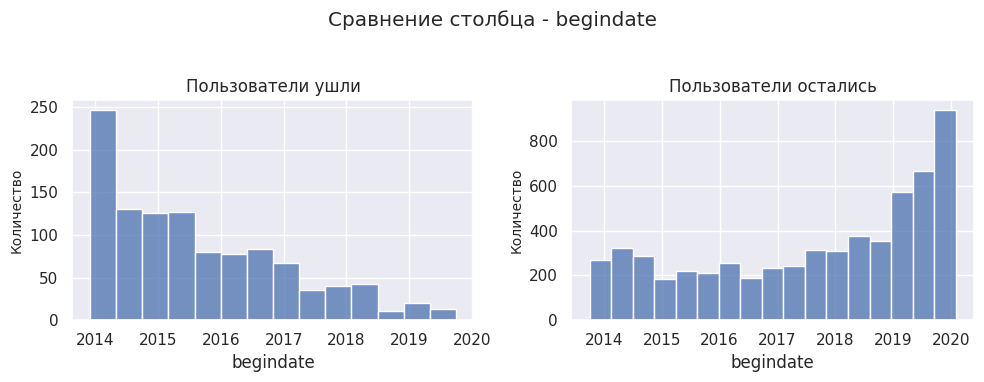

------------------------------------------------------------------------------------------------------------------------------------


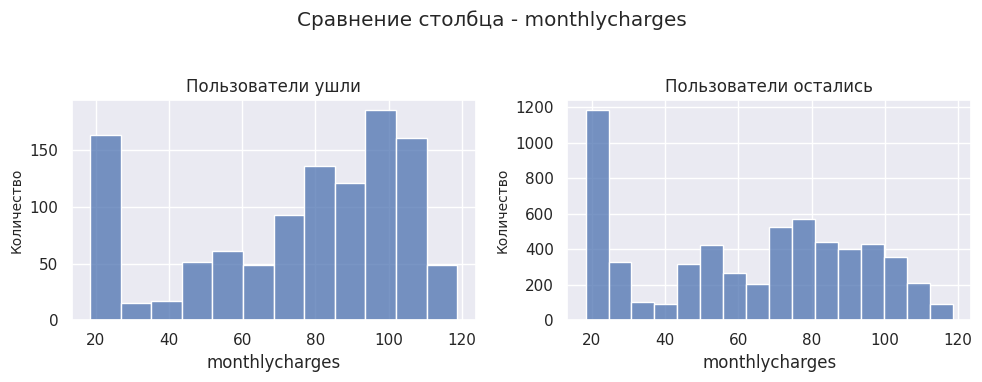

------------------------------------------------------------------------------------------------------------------------------------


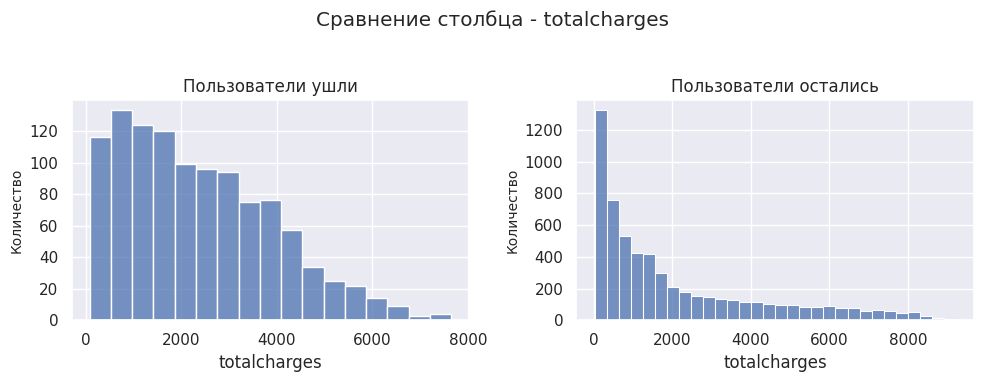

------------------------------------------------------------------------------------------------------------------------------------


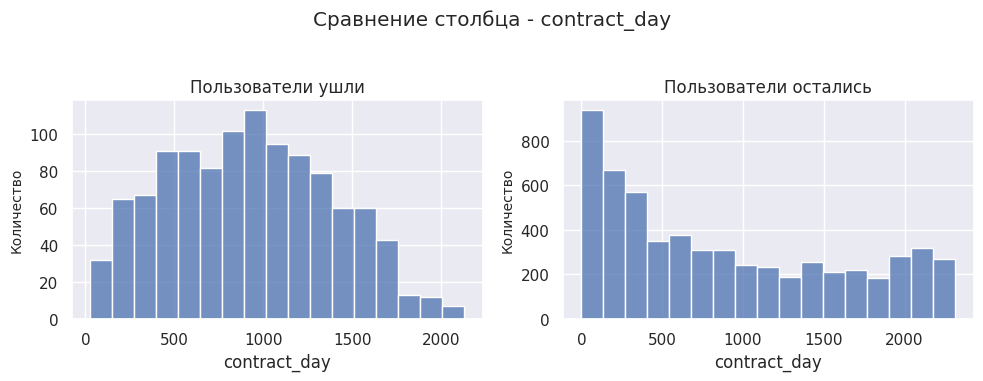

------------------------------------------------------------------------------------------------------------------------------------


In [37]:
parameters =  list(data.columns)
ind = [0,5, 6, 20]

parameters = [parameters[i] for i in ind]


for param in parameters:
    comparison_num(param)
    print(line)

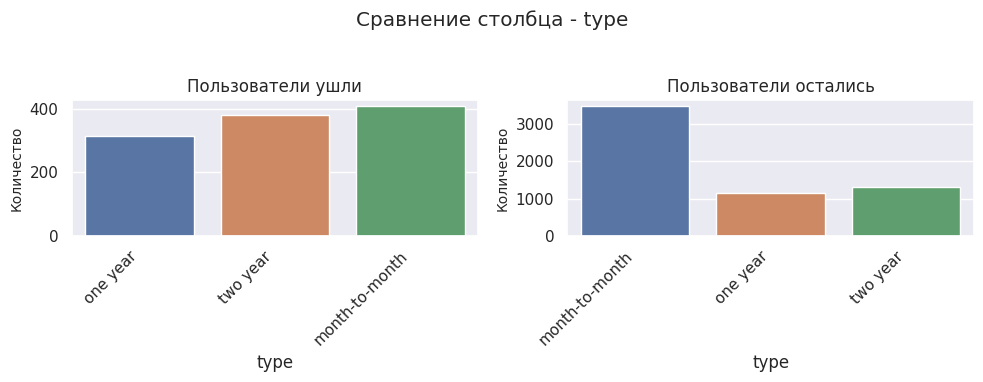

------------------------------------------------------------------------------------------------------------------------------------


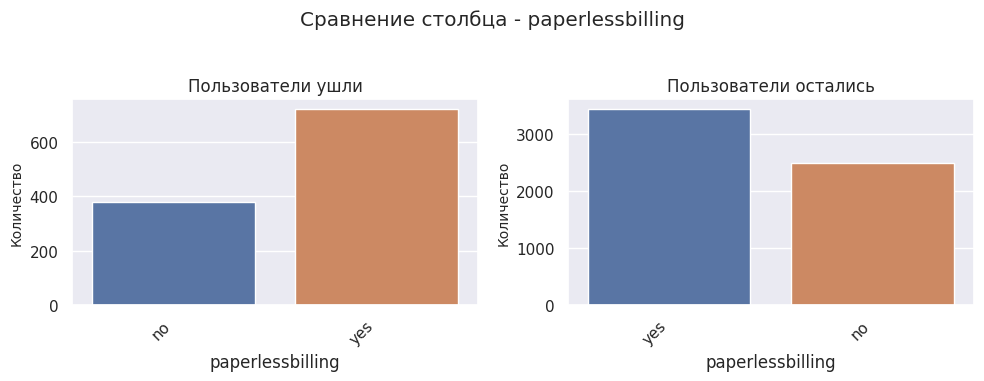

------------------------------------------------------------------------------------------------------------------------------------


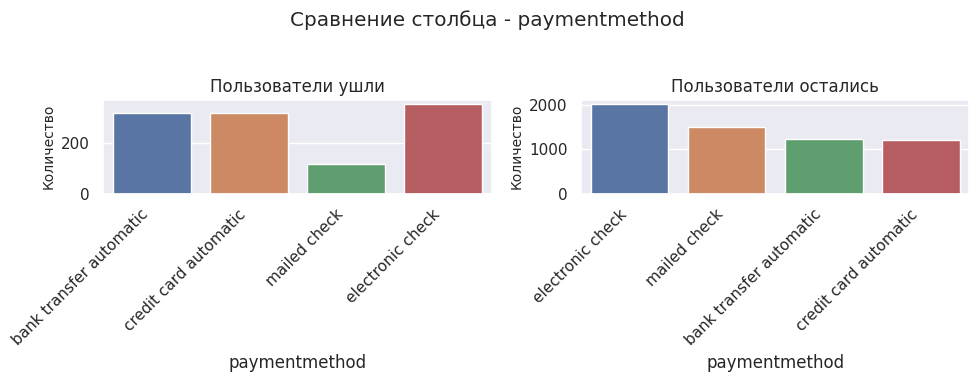

------------------------------------------------------------------------------------------------------------------------------------


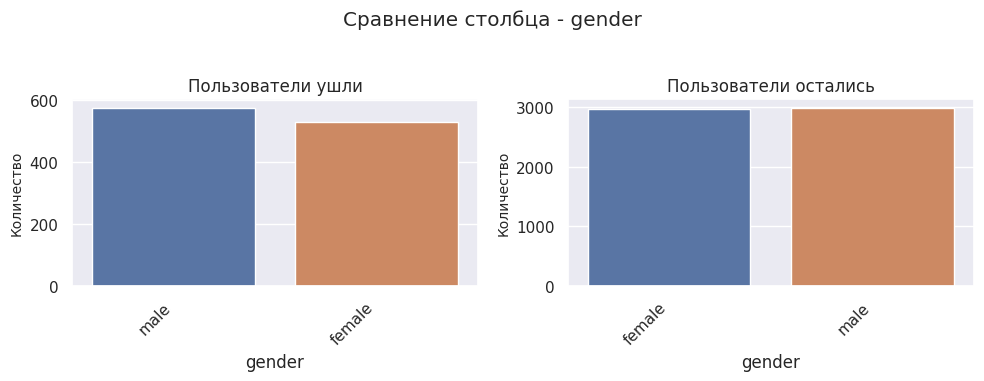

------------------------------------------------------------------------------------------------------------------------------------


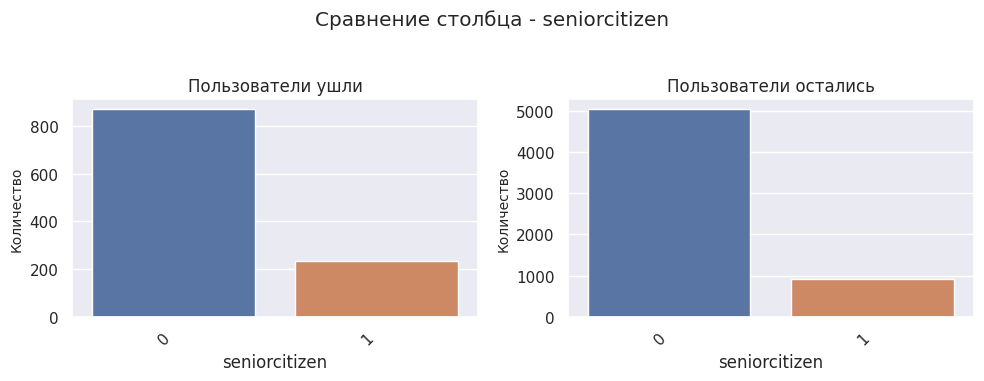

------------------------------------------------------------------------------------------------------------------------------------


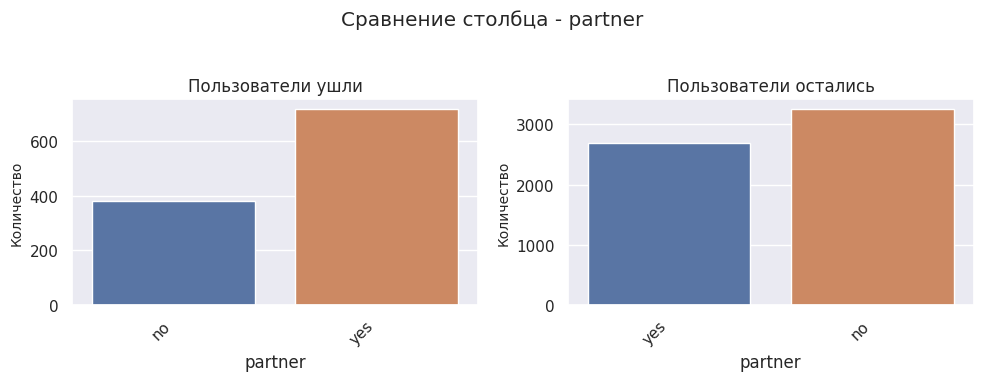

------------------------------------------------------------------------------------------------------------------------------------


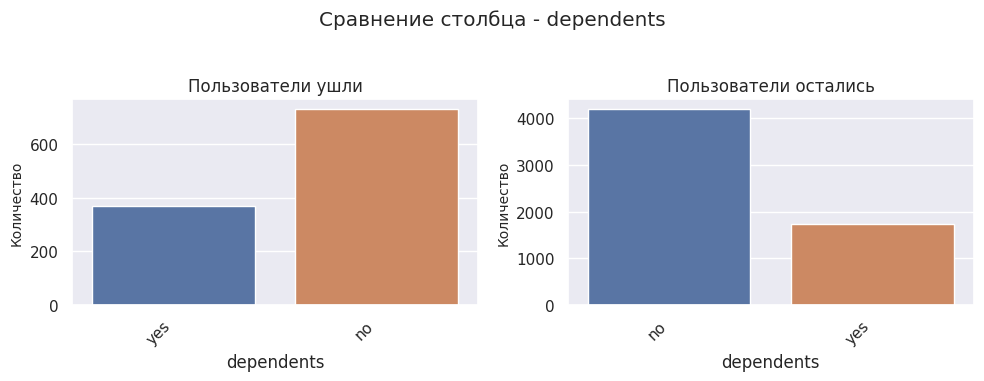

------------------------------------------------------------------------------------------------------------------------------------


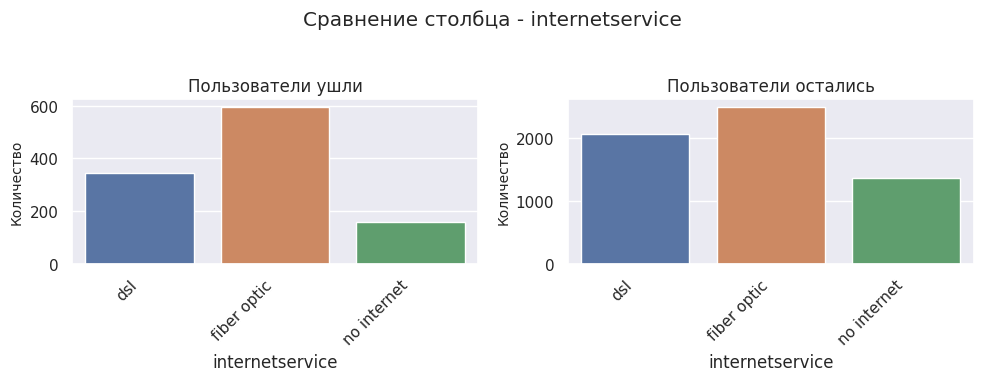

------------------------------------------------------------------------------------------------------------------------------------


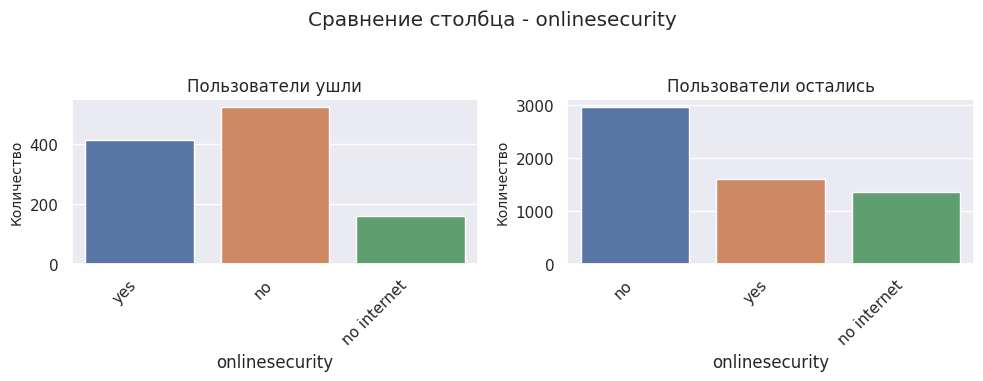

------------------------------------------------------------------------------------------------------------------------------------


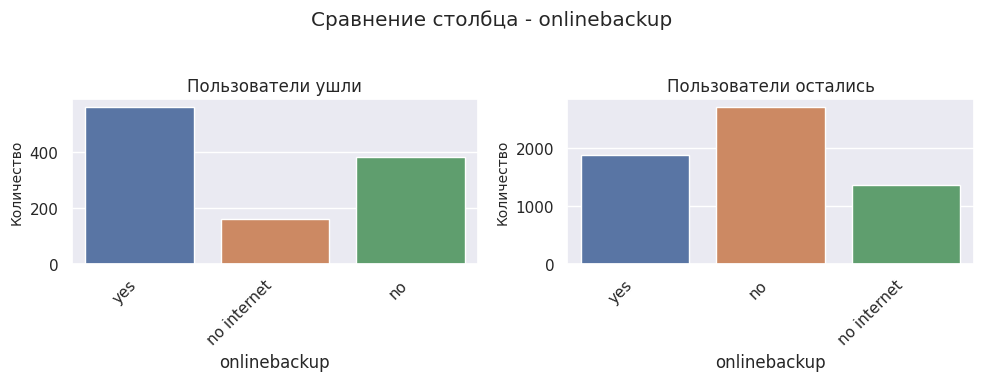

------------------------------------------------------------------------------------------------------------------------------------


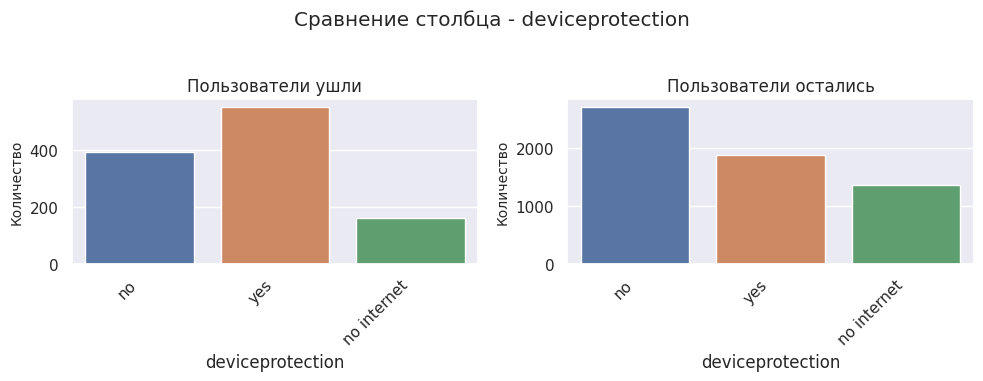

------------------------------------------------------------------------------------------------------------------------------------


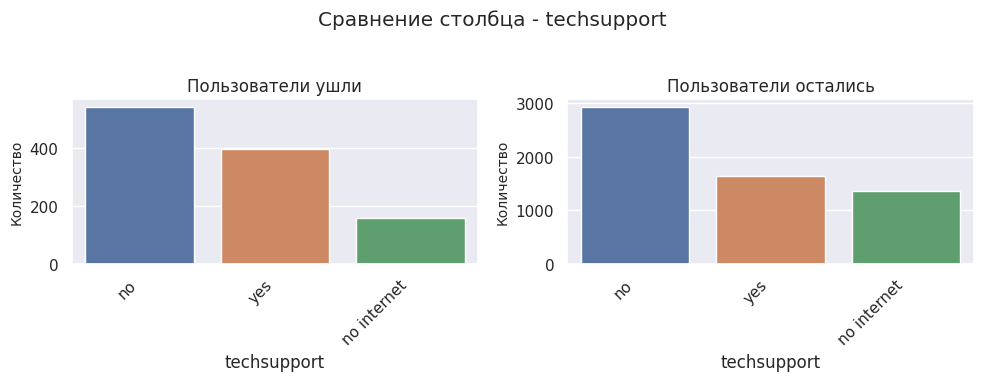

------------------------------------------------------------------------------------------------------------------------------------


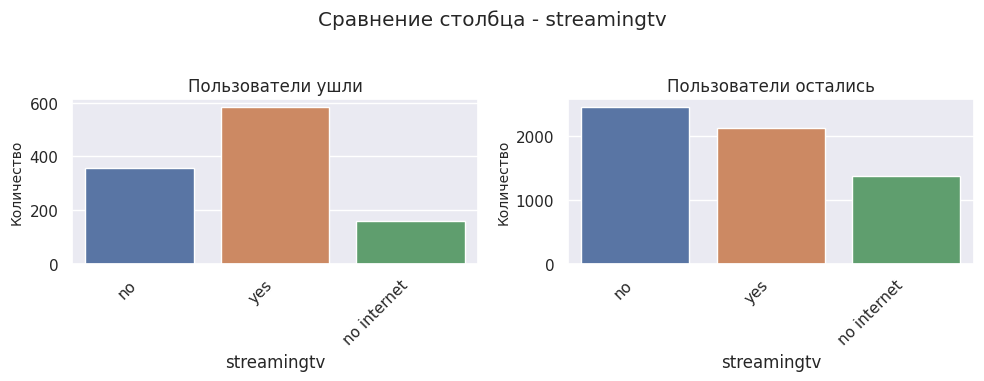

------------------------------------------------------------------------------------------------------------------------------------


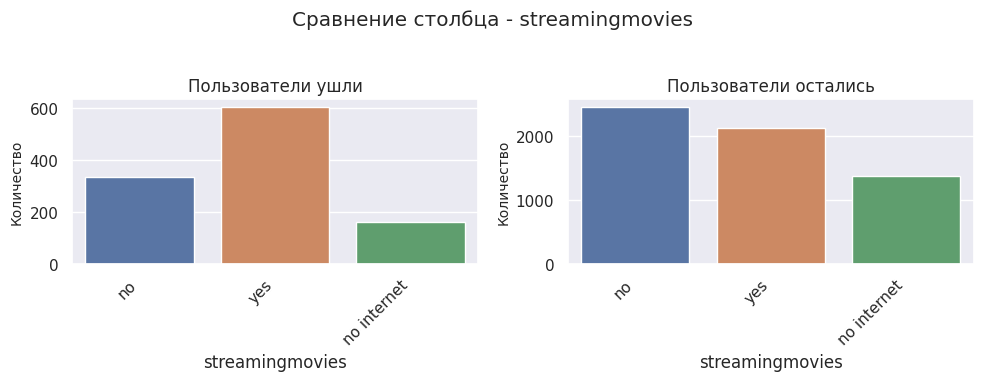

------------------------------------------------------------------------------------------------------------------------------------


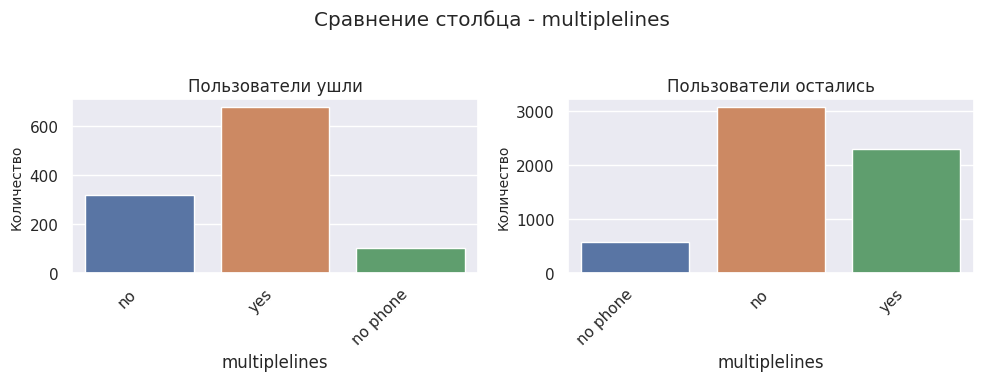

------------------------------------------------------------------------------------------------------------------------------------


In [38]:
parameters =  list(data.columns)
indices = [0,1,5,6, 19, 20] 
parameters = [word for i, word in enumerate(parameters) if i not in indices]

for param in parameters:
    comparison_cat(param)
    print(line)

Ушедшие пользователи чаще оплачивали услуги связи сразу за год/два. Возможно, это связано с акциями, которые позволяют оплатить за раз дешевле, чем итоговая сумма за 12 месяцев. Это и могло стать причиной ухода. Возможно, пользователям не предложили подобную акцию в новом году. По остальным же столбцам почти нет различия. За исключением интернет-услуг. Оставшиеся пользователи реже их покупают. Возможно, это и стало причиной ухода пользователей, так как они могли остаться недовольны качеством оплаченных ими услуг. Но сначала удалю столбец с датой подключения ибо после анализа он не нужен.

In [39]:
data = data.drop('begindate', axis=1)

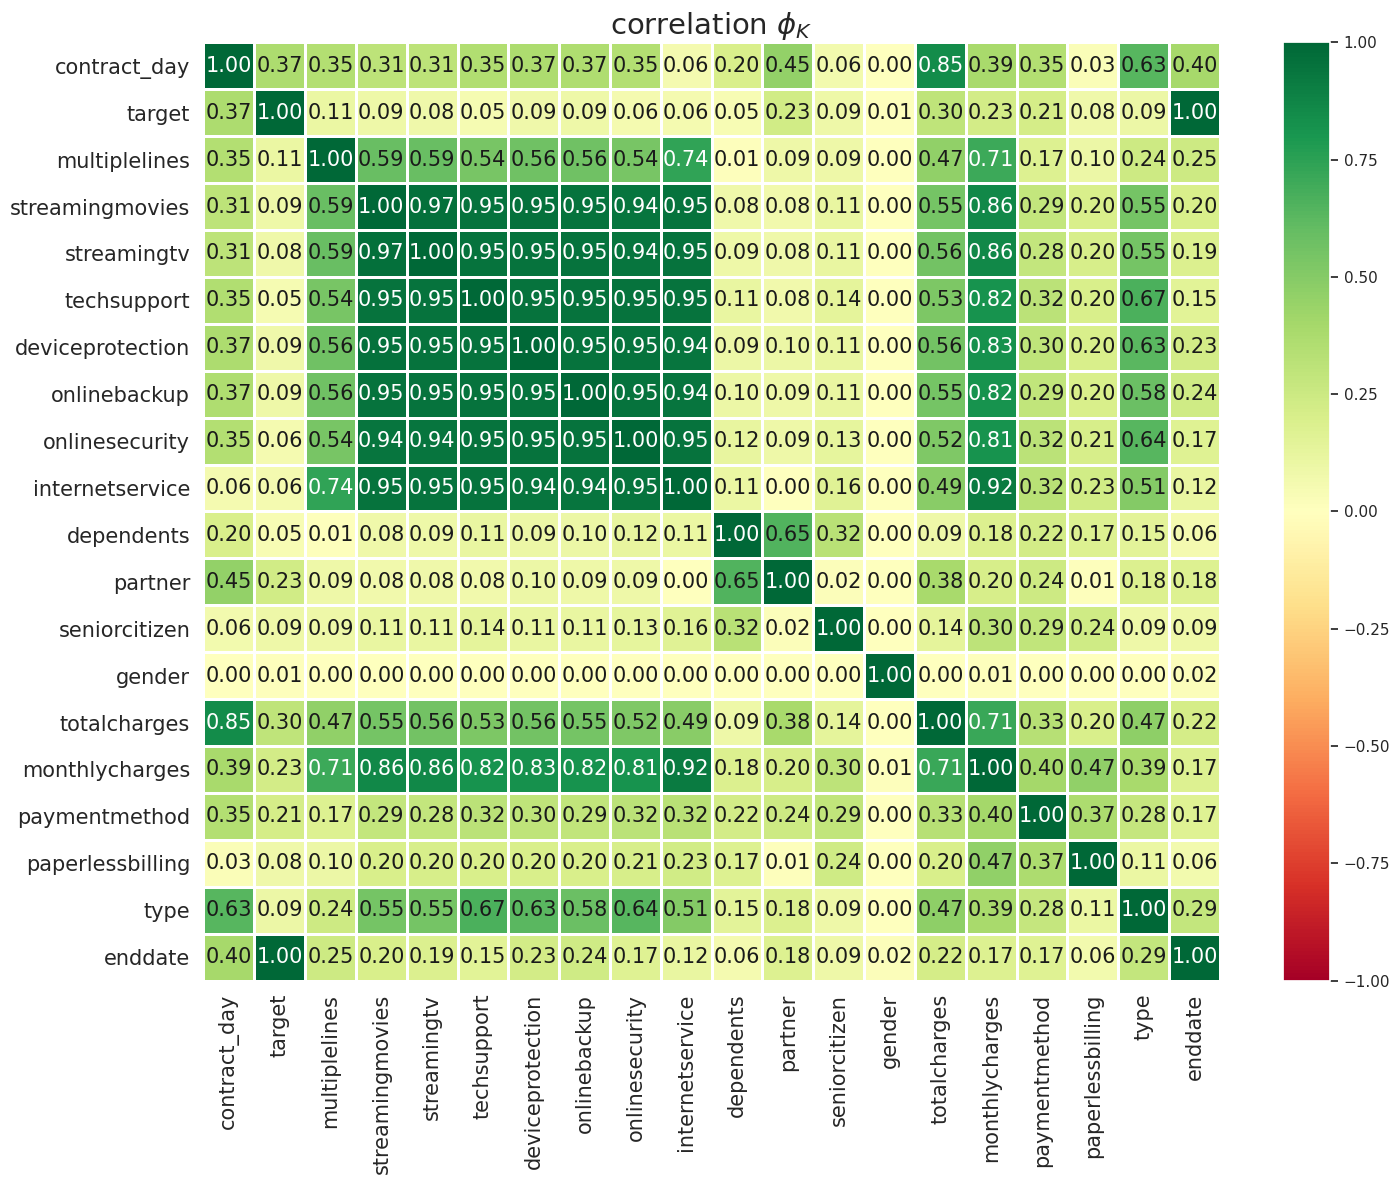

In [40]:
interval_cols = ['monthlycharges','totalcharges','contract_day']

phik_overview = data.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
)

На целевой признак лучше всего влияют такие показатели как - общие расходы абонента, тип оплаты: раз в год-два или ежемесячно, есть ли у абонента супруг или супруга.

Проверю мультиколлинеарность. Проверять буду с помощью VIF. 
<br>VIF = 1: отсутствие корреляции между предиктором и остальными предикторами
<br>1 < VIF < 5: умеренная мультиколлинеарность
<br>VIF > 5: высокая мультиколлинеарность
<br>VIF > 10: очень высокая мультиколлинеарность
<br>Исходя из этого максимально допустимое значение поставлю - 5 

In [41]:
list_columns = data.select_dtypes(include=[np.number])

vif_data = pd.DataFrame()
vif_data["feature"] = list_columns.columns

vif_data["VIF"] = [variance_inflation_factor(list_columns.values, i)
                                                for i in 
                   range(len(list_columns.columns))]


big_signs = vif_data[vif_data['VIF'] > 5.0]['feature'].tolist()

print('Список признаков и их VIF')
print(vif_data)
print(line)
print('Список признаков где VIF больше 5')
print(big_signs)

Список признаков и их VIF
          feature       VIF
0  monthlycharges  3.534754
1    totalcharges  7.875431
2          target  1.224255
3    contract_day  6.192882
------------------------------------------------------------------------------------------------------------------------------------
Список признаков где VIF больше 5
['totalcharges', 'contract_day']


Проблем с мультиколлинеарностью не обнаружено.

## <b>Обучение моделей</b>

Сначала разделю выборку на тест и трейн. 

In [42]:
data.head()

,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,target,contract_day
0,2020-02-01,month-to-month,yes,electronic check,29.85,31.04,female,0,yes,no,dsl,no,yes,no,no,no,no,no phone,0,31
1,2020-02-01,one year,no,mailed check,56.95,2071.84,male,0,no,no,dsl,yes,no,yes,no,no,no,no,0,1036
2,2020-02-01,month-to-month,yes,mailed check,53.85,226.17,male,0,no,no,dsl,yes,yes,no,no,no,no,no,0,123
3,2020-02-01,one year,no,bank transfer automatic,42.30,1960.60,male,0,no,no,dsl,yes,no,yes,yes,no,no,no phone,0,1371
4,2020-02-01,month-to-month,yes,electronic check,70.70,353.50,female,0,no,no,fiber optic,no,no,no,no,no,no,no,0,153


In [43]:
X = data.drop(['target','enddate'], axis=1)
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25
    ,random_state = RANDOM_STATE)

print(f"Строк в тренировочном датасете - {len(X_train)}") 
print(line)
print(f"Строк в тестовом датасете - {len(X_test)}")

Строк в тренировочном датасете - 5282
------------------------------------------------------------------------------------------------------------------------------------
Строк в тестовом датасете - 1761


In [44]:
cat_col_names = ['type','paperlessbilling', 'paymentmethod','gender','partner', 'dependents', 'internetservice','onlinesecurity','onlinebackup', 'deviceprotection', 'techsupport','streamingtv','streamingmovies', 'multiplelines']
num_col_names = ['monthlycharges','totalcharges','contract_day']

In [45]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), cat_col_names),
        ('num', StandardScaler(), num_col_names)
    ], 
    remainder='passthrough'
) 

In [46]:
pipe_final= Pipeline(
    [('preprocessor', data_preprocessor),
     ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))])

In [47]:
param_grid =[
    {'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
     'models__C': range(3,6),
     'preprocessor__num': [StandardScaler(), 'passthrough']},
    {'models': [KNeighborsClassifier()],
     'models__n_neighbors': range(5,10),
     'preprocessor__num': [StandardScaler(), 'passthrough']},
    {'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
     'models__max_depth': range(4, 10),
     'models__max_features': range(4,10),
     'preprocessor__num': [StandardScaler(), 'passthrough']},
    {'models': [CatBoostClassifier(random_state=RANDOM_STATE, verbose=False)],
     'models__iterations': range(20, 200),
     'models__max_depth': range(4, 10),
     'models__bagging_temperature': range(1,2),
     'preprocessor__num': [StandardScaler(), 'passthrough']},
    {'models': [XGBClassifier(scale_pos_weight=1,subsample=0.8, colsample_bytree=0.8,gamma=0)],
     'models__max_depth': range(4,8),
     'preprocessor__num': [StandardScaler(), 'passthrough']},
    {'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
     'models__n_estimators': range(40, 100, 10),
     'models__max_depth' : range(12, 24),
     'preprocessor__num': [StandardScaler(), 'passthrough']}]

In [48]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring =['roc_auc', 'precision'],
    refit = 'roc_auc',
    random_state=RANDOM_STATE,
)

In [49]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore',
                                                                                             sparse_output=False),
                                                                               ['type',
                                                                                'paperlessbilling',
                                                                                'paymentmethod',
                                                                                'gender',
                                                                                'partner',
                                                                                'dependents',
                                                                                'internetservice',
                                                                                'onlinesecurity',
                                                                                'onlinebackup',
                                                                                'deviceprotection',
                                                                                'tech...
                                                                  random_state=None, ...)],
                                         'models__max_depth': range(4, 8),
                                         'preprocessor__num': [StandardScaler(),
                                                               'passthrough']},
                                        {'models': [RandomForestClassifier(random_state=300625)],
                                         'models__max_depth': range(12, 24),
                                         'models__n_estimators': range(40, 100, 10),
                                         'preprocessor__num': [StandardScaler(),
                                                               'passthrough']}],
                   random_state=300625, refit='roc_auc',
                   scoring=['roc_auc', 'precision'])

In [50]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print(line)

roc_auc_mean = randomized_search.cv_results_['mean_test_roc_auc']
precision_mean = randomized_search.cv_results_['mean_test_precision']

best_roc_auc = roc_auc_mean[randomized_search.best_index_]
best_precision = precision_mean[randomized_search.best_index_]

print('Лучшие метрики:')
print('ROC AUC:', best_roc_auc)
print('Precision:',best_precision)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['type', 'paperlessbilling',
                                                   'paymentmethod', 'gender',
                                                   'partner', 'dependents',
                                                   'internetservice',
                                                   'onlinesecurity',
                                                   'onlinebackup',
                                                   'deviceprotection',
                                                   'tec

Создам НС. Но для начала для НС создам датафрейм где буду преобразованные данные. 

In [51]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train[num_col_names])
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])

encoder_col_names = encoder.get_feature_names_out()
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)

In [52]:
class Net(nn.Module):
    def __init__(self, n_in, n_1, n_out):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in, n_1)
        self.act1 = nn.Tanh()
        self.fc2 = nn.Linear(n_1, n_out)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

n_splits = 5
num_epochs = 1000  

roc_auc_scores = []
accuracy_scores = []

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

n_in = X_train.shape[1]
n_1 = 40
n_out = 1

for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f"\nFold {fold + 1}/{n_splits}")
    
    X_train_fold = X_train.iloc[train_index].values  
    y_train_fold = y_train.iloc[train_index].values  
    X_val_fold = X_train.iloc[val_index].values     
    y_val_fold = y_train.iloc[val_index].values      
    
    X_train_tensor = torch.tensor(X_train_fold, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_fold, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val_fold, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_fold, dtype=torch.float32).view(-1, 1)
    
    model = Net(n_in, n_1, n_out)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.BCELoss()
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        
        preds_train = model(X_train_tensor).flatten()
        loss_train = loss_fn(preds_train, y_train_tensor.squeeze())
        loss_train.backward()
        optimizer.step()
        
        if epoch % 200 == 0 or epoch == num_epochs - 1:
            model.eval()
            with torch.no_grad():
                predict_val = model(X_val_tensor).flatten()
                y_pred_bin = (predict_val > 0.5).float()
                
                roc_auc = roc_auc_score(
                    y_val_tensor.numpy().squeeze(), 
                    predict_val.numpy()
                )
                accuracy = accuracy_score(
                    y_val_tensor.numpy().squeeze(), 
                    y_pred_bin.numpy()
                )
                
                print(f'Эпоха № {epoch}')
                print(f'ROC AUC: {roc_auc:.4f}')
                print(f'Accuracy: {accuracy:.4f}')


Fold 1/5
Эпоха № 0
ROC AUC: 0.5162
Accuracy: 0.3680
Эпоха № 200
ROC AUC: 0.6380
Accuracy: 0.8477
Эпоха № 400
ROC AUC: 0.7353
Accuracy: 0.8505
Эпоха № 600
ROC AUC: 0.7799
Accuracy: 0.8581
Эпоха № 800
ROC AUC: 0.8120
Accuracy: 0.8609
Эпоха № 999
ROC AUC: 0.8230
Accuracy: 0.8628

Fold 2/5
Эпоха № 0
ROC AUC: 0.4648
Accuracy: 0.7010
Эпоха № 200
ROC AUC: 0.6991
Accuracy: 0.8524
Эпоха № 400
ROC AUC: 0.7785
Accuracy: 0.8761
Эпоха № 600
ROC AUC: 0.8039
Accuracy: 0.8808
Эпоха № 800
ROC AUC: 0.8136
Accuracy: 0.8827
Эпоха № 999
ROC AUC: 0.8164
Accuracy: 0.8798

Fold 3/5
Эпоха № 0
ROC AUC: 0.5699
Accuracy: 0.7547
Эпоха № 200
ROC AUC: 0.6920
Accuracy: 0.8494
Эпоха № 400
ROC AUC: 0.8066
Accuracy: 0.8712
Эпоха № 600
ROC AUC: 0.8424
Accuracy: 0.8731
Эпоха № 800
ROC AUC: 0.8491
Accuracy: 0.8731
Эпоха № 999
ROC AUC: 0.8519
Accuracy: 0.8778

Fold 4/5
Эпоха № 0
ROC AUC: 0.5513
Accuracy: 0.2708
Эпоха № 200
ROC AUC: 0.6534
Accuracy: 0.8466
Эпоха № 400
ROC AUC: 0.7699
Accuracy: 0.8608
Эпоха № 600
ROC AUC: 0.

Лучше всего себя показала CatBoostClassifier. Тесты сделаю на ней. Так-же добавлю метрику Accuracy которая показывает количество провильных и неправильных ответов выводит их соотношение. Простыми словами Accuracy показывает процент верных ответов. 

0.8065884840643823
0.8075251913989863
0.8063972010071923

In [53]:
y_test_pred = randomized_search.best_estimator_.predict_proba(X_test)[:, 1]

roc_auc_score_test = roc_auc_score(y_test, y_test_pred)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score_test}')
print(line)
y_test_pred = (y_test_pred >= 0.5).astype(int) 
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f'Accuracy на тестовой выборке: {accuracy_test}')

Метрика ROC-AUC на тестовой выборке: 0.8619168185338212
------------------------------------------------------------------------------------------------------------------------------------
Accuracy на тестовой выборке: 0.8722316865417377


In [54]:
final_model = randomized_search.best_estimator_

importances = final_model.named_steps['models'].feature_importances_
feature_names = final_model.named_steps['preprocessor'].get_feature_names_out()

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Топ-10 наиболее важных признаков:")
print(importance_df.head(10))

Топ-10 наиболее важных признаков:
                            Feature  Importance
27                num__contract_day   45.513572
25              num__monthlycharges    7.926482
26                num__totalcharges    6.796742
1                ohe__type_two year    6.462292
7                  ohe__partner_yes    4.000847
0                ohe__type_one year    3.490379
24           ohe__multiplelines_yes    3.174086
14            ohe__onlinebackup_yes    2.382256
28         remainder__seniorcitizen    2.150541
5   ohe__paymentmethod_mailed check    1.965929


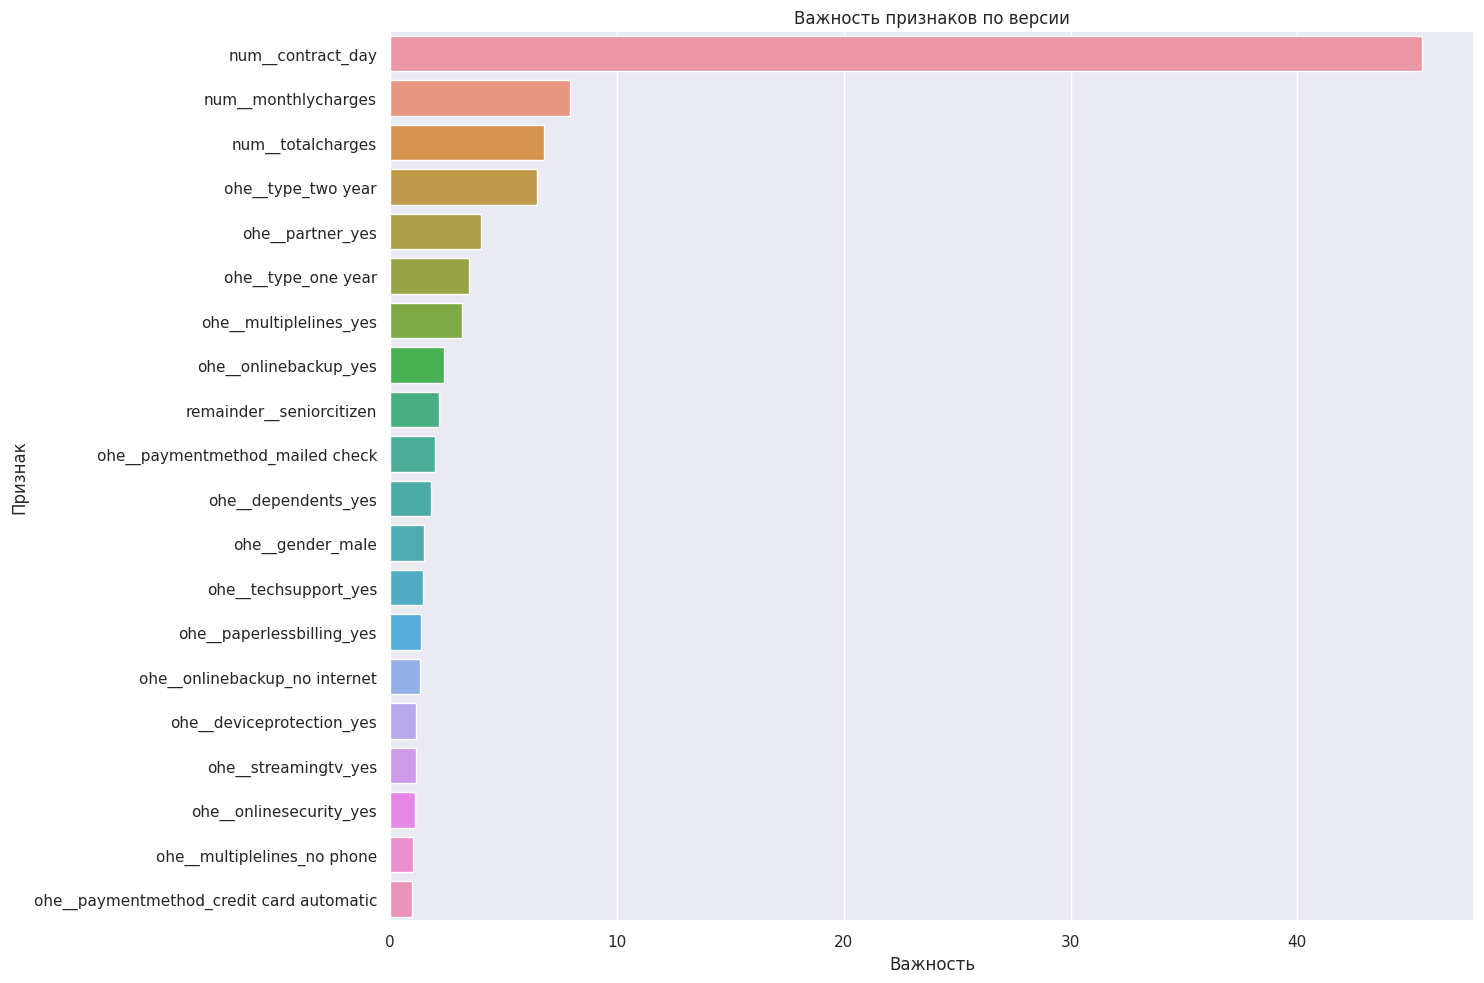

In [55]:
plt.figure(figsize=(15, 10))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Важность признаков по версии')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

Самый важный для модели признак — total charges, общие расходы. Это сходится с матрицей корреляции. 

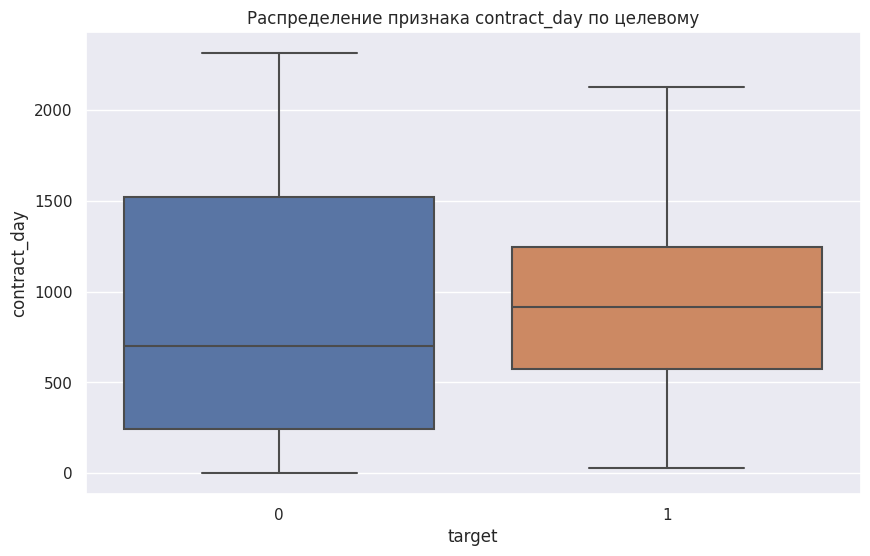

In [56]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y='contract_day', data=data)
plt.title('Распределение признака contract_day по целевому')
plt.show()

Видно, что количетсво дней больше у тех клинетов котоыре остались.

Построю матрицу ошибок.

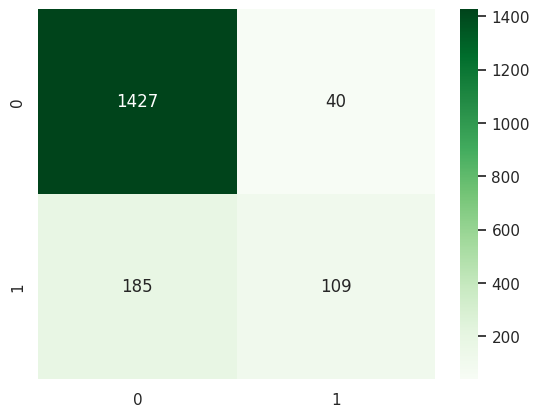

In [57]:
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens');

Модель хорошо предсказывает значение 0. Со значением 1 проблемы, она часто предсказывает это значение как 0, и в итоге люди, которые будут отказываться от услуг, так и не будут предсказаны. А вот люди, которые будут продолжать пользоваться услугами, попадут в список потенциальных отказников. А если вернуться к связи важного признака, то тут становится понятно, почему так. Ибо так как раз и есть большое количество нулевых значений. 

Вывод. 
<br>Что CatBoostClassifier что НС показали высокие метрики что позволяют использовать любую из них. Тест был сделан на CatBoostClassifier, получившеяся метрика равна -  0.95. 
<br>Уход многих сюдей зачастую пересекается с интернет услугами. Видимо людям не нравиться качество или иные проблемы связанные с предоставляемым интернетом в компании. Рекомендация - усилить рекламу и предложения для холостых людей без детей не пенсионного возраста. 